This notebook presents the design of a machine learning-based classifier for the differentiation between eypes-open and eyes-close using features extracted from electroencephalograph(EEG) signals.After the EEG signals are preprocessed and feature extraction, four machine learning algorithm (KNN, Naive Bayes model, LG and SVM) are chosen to be applied for classification.

# About Data


The signals were selected at the **Oz** channel of the EEG data from one
subject in two separate sessions (eyes-open [EO] and eyes-closed [EC]). There are
60 trials for EO and EC conditions, respectively, as training samples and another
60 trials with unknown labels as test samples. The task of this example is training a
classifier to separate EO and EC conditions from training samples and identifying
labels for test samples.


data_classification.mat contains: 

1.  ec (60 EEG trials for eyes-closed condition; each
trial has 2000 time points); 
2. eo (60 EEG trials for eyes-open condition; each trial
has 2000 time points); 
3. test_samples (60 EEG trials for testing; each trial has 2000
time points); 
4. test_labels (60 binary numbers, 1 or 0, representing the class labels
for the test samples). 

**It should be noted that the sampling rate/sampling frequency(the number of samples per second ) of the EEG data is 200, and the recording length for each trial is 10 sec.**

In [1]:
import os
os.getcwd()
os.chdir('C:/Shuai/Projects/Neroscience/EEG_Signal_Processing_and_Feature_Extrac')

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets,svm,metrics
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from IPython.display import Javascript

In [3]:
import scipy.io
mat = scipy.io.loadmat('data_classification.mat')

In [4]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ec', 'eo', 'test_labels', 'test_samples'])

In [5]:
ec=mat['ec']#numpy.ndarray
eo=mat['eo']
test_labels=mat["test_labels"]
test_samples=mat['test_samples']

In [6]:
ec.shape,eo.shape,test_labels.shape,test_samples.shape

((2000, 60), (2000, 60), (60, 1), (2000, 60))

# Signals Preprocessing

### Remove Direct Current ( DC ) Offset 

In [7]:
def balance(data):
    balanced=[]
    for i in range(0,ec.shape[1]):
        balanced.append(data[:,i]-np.mean(data[:,i],axis=-1))
    return balanced

### Calculate Power Spectral Density(PSD)

<div class="alert alert-block alert-success">
Welch’s method computes an estimate of the power spectral density(PSD) by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms.

use **signal** package in scipy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
    
</div>

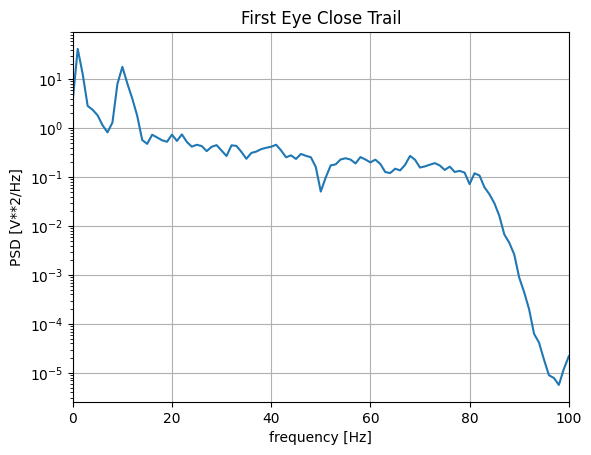

In [8]:
# Get PSD for first eye close trail  
(Fec1b, PSDec1b)= scipy.signal.welch(balance(ec)[0], fs=200, nperseg=200)# fs:sampling frequency

fig, ax = plt.subplots()
plt.semilogy(Fec1b, PSDec1b) # Make a plot with log scaling on the y axis.
plt.xlim([0, 100])
#plt.ylim([0.5e-2, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid(True)
ax.set_title('First Eye Close Trail')
plt.show()

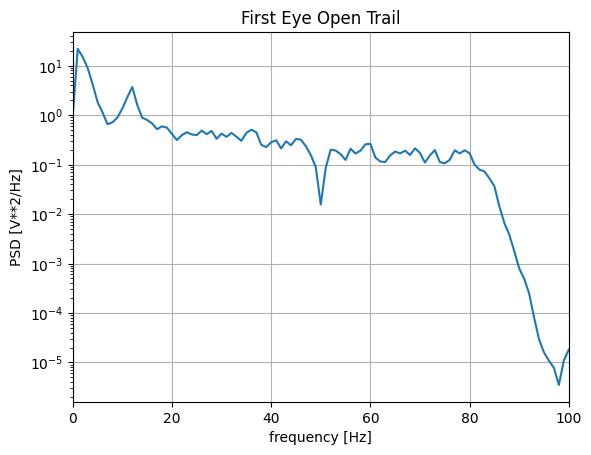

In [9]:
# Get PSD for first eye open trail  
(Feo1b, PSDeo1b)= scipy.signal.welch(balance(eo)[0], fs=200, nperseg=200)

fig, ax = plt.subplots()
plt.semilogy(Feo1b, PSDeo1b)
plt.xlim([0, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid(True)
ax.set_title('First Eye Open Trail')
plt.show()


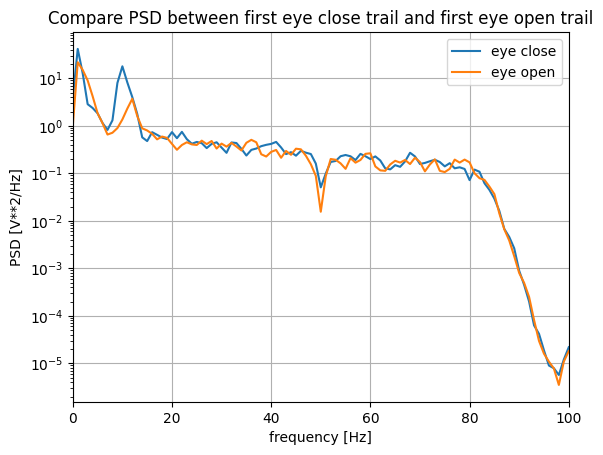

In [10]:
#compare PSD between first eye close trail and first eye open trail in plot
fig, ax = plt.subplots()
plt.semilogy(Fec1b, PSDec1b,label='eye close')
plt.semilogy(Feo1b, PSDeo1b,label='eye open')
plt.xlim([0, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid(True)
ax.legend()
ax.set_title('Compare PSD between first eye close trail and first eye open trail')
plt.show()

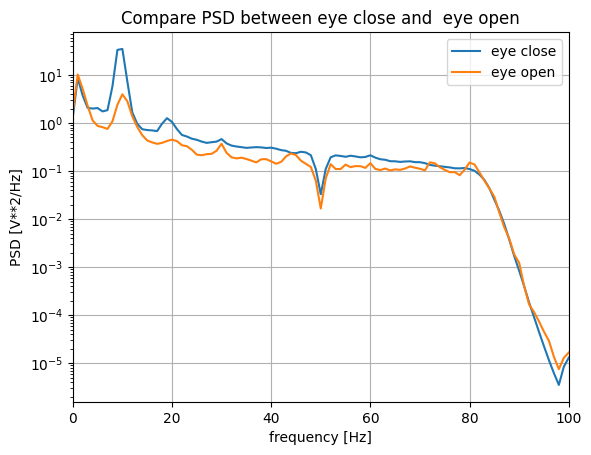

In [11]:
#average EYE CLOSE 
Fecb=[]
PSDecb=[]
for i in range(0,ec.shape[1]):
    (Feci, PSDeci)= scipy.signal.welch(balance(ec)[i], fs=200, nperseg=200)
    PSDecb.append(PSDeci)
    Fecb.append(Feci)
M_PSDecb=np.mean(PSDecb, axis=0)
M_Fecb=np.mean(Fecb, axis=0)

#average EYE OPEN
Feob=[]
PSDeob=[]
for i in range(0,eo.shape[1]):
    (Feoi, PSDeoi)= scipy.signal.welch(balance(eo)[i], fs=200, nperseg=200)
    PSDeob.append(PSDeoi)
    Feob.append(Feoi)
M_PSDeob=np.mean(PSDeob, axis=0)
M_Feob=np.mean(Feob, axis=0)


fig, ax = plt.subplots()
plt.semilogy(M_Fecb, M_PSDecb,label='eye close')
plt.semilogy(M_Feob, M_PSDeob,label='eye open')
plt.xlim([0, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid(True)
ax.legend()
ax.set_title('Compare PSD between eye close and  eye open')
plt.show()
fig.savefig("Compare PSD between eye close and  eye open.png")

### Fast Fourier Transforms with MNE


1.	Do baseline correction (DC Offset) ( balance(eo),balance(ec))
2.	Filter data between 1 and 40 Hz  
3.	Do FFT calculation
4.	Plot raw and FFT and compare to PSD plots


In [12]:
import mne
def filt(data):
    info = mne.create_info(ch_names=['oz'] * 60, sfreq=200,ch_types=['eeg'] * 60,verbose=False)
    raw = mne.io.RawArray(data=np.asarray(balance(data)), info=info, verbose=False)
# 2.Filter data between 0.01 and 40 Hz  
    fmin = 1 #For FIR filters, the lower pass-band edge
    fmax = 40 #For FIR filters, the upper pass-band edge
    raw.filter(fmin, fmax, verbose=False)
    return raw


In [13]:
# 2.Filter data between 0.01 and 40 Hz
F_ec=filt(ec).get_data()
F_eo=filt(eo).get_data()
F_eo.shape,F_ec.shape

C:\Users\shuail\AppData\Local\Temp\ipykernel_17036\343625824.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'oz'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=['oz'] * 60, sfreq=200,ch_types=['eeg'] * 60,verbose=False)
C:\Users\shuail\AppData\Local\Temp\ipykernel_17036\343625824.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'oz'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=['oz'] * 60, sfreq=200,ch_types=['eeg'] * 60,verbose=False)


((60, 2000), (60, 2000))

C:\Users\shuail\Anaconda3\envs\elephant\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


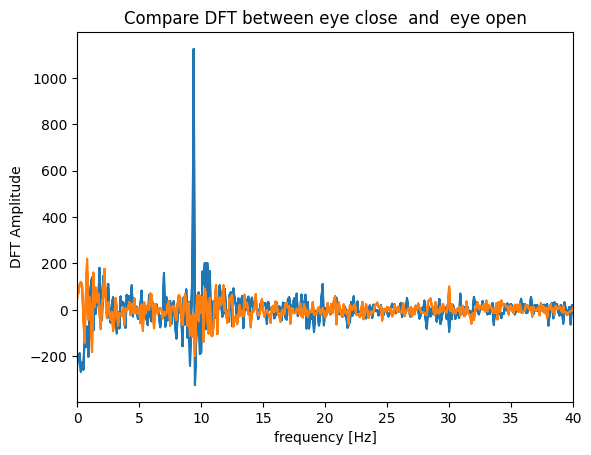

In [14]:
# 3.Do FFT calculation

from scipy.fft import fft, fftfreq
f=fftfreq(n=2000,d=1/200)
fft_eo=fft(F_eo)
fft_ec=fft(F_ec)


fig, ax = plt.subplots()
plt.plot(np.abs(f),np.mean(fft_ec,axis=0) ,label='eye close')
plt.plot(np.abs(f),np.mean(fft_eo,axis=0),label='eye open')
plt.xlim([0, 40])
plt.xlabel('frequency [Hz]')
plt.ylabel('DFT Amplitude')
ax.set_title('Compare DFT between eye close  and  eye open')
#DFT:discrete fourier transform
plt.show()
#plt.ylim([0.0001, 2000])
ax.legend()
plt.show()

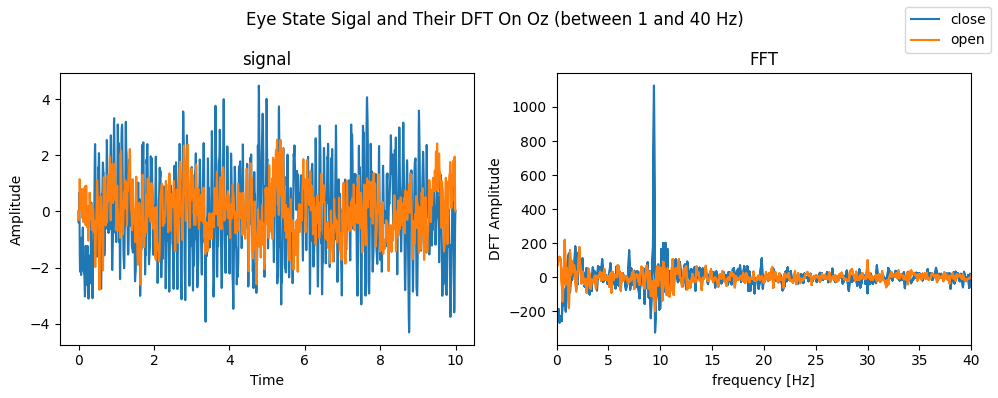

In [15]:
from scipy.fft import fft, fftfreq
#Do FFT calculation

f=fftfreq(n=2000,d=1/200)
fft_eo=fft(F_eo)
fft_ec=fft(F_ec)

t = np.arange(0, 10, 0.005)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(hspace = .3, wspace=.3)

axs[0].plot(t,np.mean(F_ec,axis=0) ,label='eye close')
axs[0].plot(t,np.mean(F_eo,axis=0),label='eye open')
#axs[0].set_xlim(0, 40)
#axs[0].set_xlabel('frequency [Hz]')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time')
axs[0].set_title('signal')

axs[1].plot(np.abs(f),np.mean(fft_ec,axis=0) ,label='eye close')
axs[1].plot(np.abs(f),np.mean(fft_eo,axis=0),label='eye open')
axs[1].set_xlim(0, 40)
axs[1].set_xlabel('frequency [Hz]')
axs[1].set_ylabel('DFT Amplitude')
axs[1].set_title('FFT')

fig.suptitle('Eye State Sigal and Their DFT On Oz (between 1 and 40 Hz)')#, fontsize=14)
fig.legend(labels=['close','open'],loc="upper right")
fig.tight_layout()
fig.savefig("Eye State Sigal and Their DFT (between 1 and 40 Hz).png")

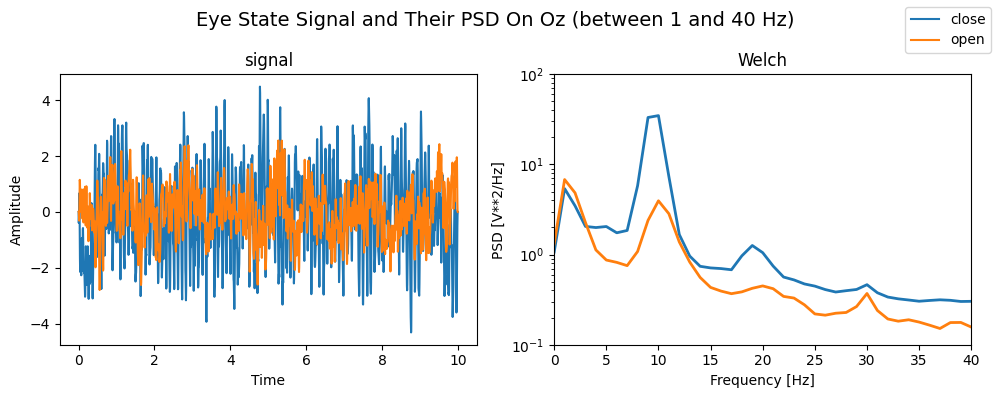

In [16]:
t = np.arange(0, 10, 0.005)

(F1o, P1o)= scipy.signal.welch(F_eo, fs=200, nperseg=200)
(F1c, P1c)= scipy.signal.welch(F_ec, fs=200, nperseg=200)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(hspace = .3, wspace=.3)

axs[0].plot(t,np.mean(F_ec,axis=0) ,label='eye close')
axs[0].plot(t,np.mean(F_eo,axis=0),label='eye open')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time')
axs[0].set_title('signal')

axs[1].semilogy(F1c, np.mean(P1c,axis=0),lw=2.0,label='eye close')
axs[1].semilogy(F1o, np.mean(P1o,axis=0),lw=2.0,label='eye open')
axs[1].set_xlim(0, 40)
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('PSD [V**2/Hz]')
axs[1].set_ylim(0.1, 100)
axs[1].set_title('Welch')

fig.suptitle('Eye State Signal and Their PSD On Oz (between 1 and 40 Hz)', fontsize=14)
fig.legend(labels=['close','open'],loc="upper right")
fig.tight_layout()
fig.savefig("Eye State Signal and Their PSD (between 1 and 40 Hz).png")



#### Power different
<div class="alert alert-block alert-info">
    greatest difference between
two states was that <b> the power in the eye closed state was
much higher than that in the eye open state <b>
   </div>

### Feature Extraction 

<div class="alert alert-block alert-success">
alpha-band(8-12Hz) power in eye close is significantly larger than in eye open.
    
    

extrat PSD in alpha-band(8-12Hz) for all trails(60 ec+60 eo) and labels of all samples:<b>1 for eo; 0 for ec.<b>
    
</div>

In [17]:
PSDec_a=PSDecb[8:13]

In [18]:
import pandas as pd
PSDec_a=pd.DataFrame([i[8:13] for i in PSDecb])
PSDec_a['label']=0

PSDeo_a=pd.DataFrame([i[8:13] for i in PSDeob])
PSDeo_a['label']=1

data=pd.concat([PSDec_a,PSDeo_a])
X=data.iloc[:,[0,1,2,3,4]]
y=data['label']

### Feature Extraction for test_samples

In [19]:
Ftest=[]
PSDtest=[]
for i in range(0,test_samples.shape[1]):
    (Ftesti, PSDtesti)= scipy.signal.welch(balance(test_samples)[i], fs=200, nperseg=200)
    PSDtest.append(PSDtesti)
    Ftest.append(Ftesti)
#print(len(PSDtest),len(Ftest))
# test_samples in alpha-band 
PSDtest_a=pd.DataFrame([i[8:13] for i in PSDtest])
#PSDtest_a.shape

# Machine learning with 4 models

KNN, Naive Bayes model, LG, SVM



In [20]:
def classification_report(model_name,y_test,predicted):
    report=metrics.classification_report(y_test,predicted)
    print("{} classification_report is \n\n{}".format(model_name,report) )

In [21]:
def confusion_matrix(y_test,predicted):
    confusion_matrix=metrics.confusion_matrix(y_test,predicted)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()
    confusion_matrix

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90, 5) (30, 5) (90,) (30,)


svm model classification_report is 

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.79      1.00      0.88        15

    accuracy                           0.87        30
   macro avg       0.89      0.87      0.86        30
weighted avg       0.89      0.87      0.86        30



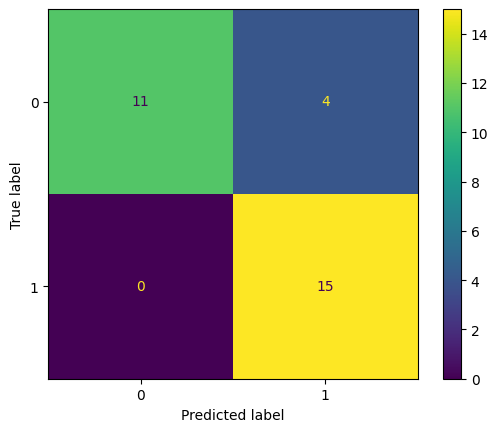

In [23]:
# svm model
from sklearn import svm
svm=svm.SVC(gamma=0.001,kernel='linear',random_state=0).fit(X_train, y_train)
predicted_svm = svm.predict(X_test)
#predicted_svm,y_test
classification_report('svm model',y_test,predicted_svm)
confusion_matrix(y_test,predicted_svm)

Naive Bayes model classification_report is 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.83      1.00      0.91        15

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30



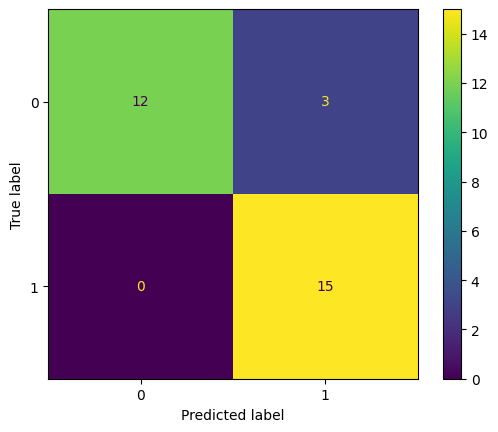

In [24]:
# Naive Bayes model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
predicted_gnb= gnb.predict(X_test)
classification_report('Naive Bayes model',y_test,predicted_gnb)
confusion_matrix(y_test,predicted_gnb)

logistic Regression model classification_report is 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.83      1.00      0.91        15

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30



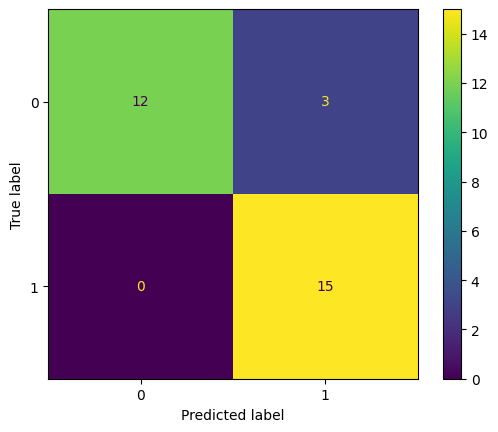

In [25]:
# logistic Regression model
from sklearn.linear_model import LogisticRegression
lg= LogisticRegression(random_state=0).fit(X_train, y_train)
predicted_lg=lg.predict(X_test)
 
classification_report('logistic Regression model',y_test,predicted_lg)
confusion_matrix(y_test,predicted_lg)

knn model classification_report is 

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.88      1.00      0.94        15

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



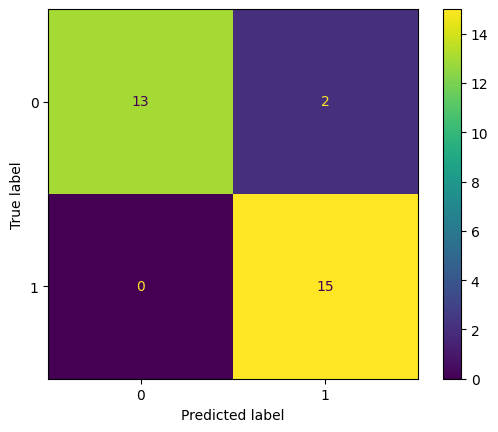

In [26]:
# knn model
from sklearn.neighbors import KNeighborsClassifier
knn =KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
predicted_knn=knn.predict(X_test)

classification_report('knn model',y_test,predicted_knn)
confusion_matrix(y_test,predicted_knn)

In [27]:
acc_gnb = np.zeros(1000)
acc_lg = np.zeros(1000)
acc_knn= np.zeros(1000)
acc_svm= np.zeros(1000)
randseed=0
from sklearn import svm
for i in range(1000):
    
    X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, shuffle=True)
    
    # svm
    s=svm.SVC()
    y_pred_svm = s.fit(X_train, y_train).predict(X_test)
    acc_svm[i] = (sum(y_pred_svm== y_test))/len(y_test)
    
    # Naive Bayes
    gnb = GaussianNB(var_smoothing = 1e-9)
    y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)
    acc_gnb[i] = (sum(y_pred_gnb== y_test))/len(y_test)

    # Logistic regression
    lg = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred_lg = lg.predict(X_test)
    acc_lg[i] = sum(y_pred_lg==y_test)/len(y_test)
     
    # KNN
    knn = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    acc_knn[i] = sum(y_pred_knn==y_test)/len(y_test)
    
mean_acc_svm = acc_svm.mean()
mean_acc_gnb = acc_gnb.mean()
mean_acc_lg = acc_lg.mean()
mean_acc_knn = acc_knn.mean()  
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('mean accuracy for running 1000 times')

print('testing accuracy for svm: %s'
      % str(round(mean_acc_svm,5)))
print('testing accuracy for Naive Bayes: %s'
      % str(round(mean_acc_gnb,5)))
print('testing accuracy for Logistic Regression: %s'
      % str(round(mean_acc_lg,5)))
print('testing accuracy for KNN: %s'
      % str(round(mean_acc_knn,5)))


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mean accuracy for running 1000 times
testing accuracy for svm: 0.90288
testing accuracy for Naive Bayes: 0.92925
testing accuracy for Logistic Regression: 0.91508
testing accuracy for KNN: 0.92654


**for confusion_matrix: almost same**

**for mean accuracy  1000 times: Naive>KNN>LG>SVM**

### Predict for test_samples

Naive Bayes model classification_report is 

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.85      0.97      0.91        30

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



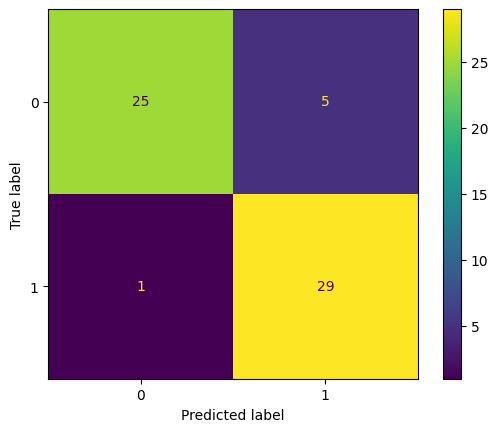

In [28]:
# predict with test sample
predicted_gnb= gnb.predict(PSDtest_a)
classification_report('Naive Bayes model',test_labels,predicted_gnb)
confusion_matrix(test_labels,predicted_gnb)

knn model classification_report is 

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.93      0.90      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



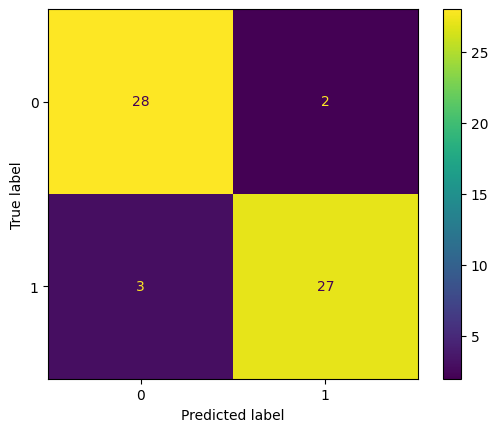

In [29]:
predicted_knn=knn.predict(PSDtest_a)

classification_report('knn model',test_labels,predicted_knn)
confusion_matrix(test_labels,predicted_knn)

logistic Regression model classification_report is 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



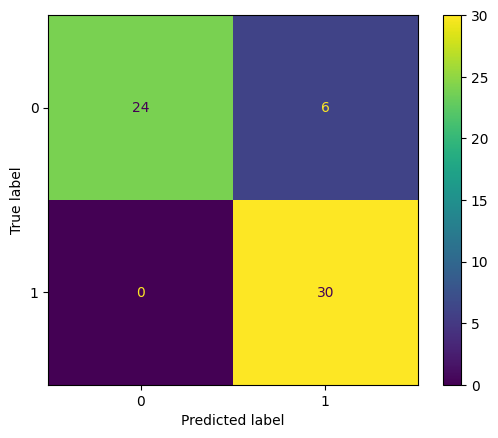

In [30]:
predicted_lg=lg.predict(PSDtest_a)
 
classification_report('logistic Regression model',test_labels,predicted_lg)
confusion_matrix(test_labels,predicted_lg)

svm model classification_report is 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



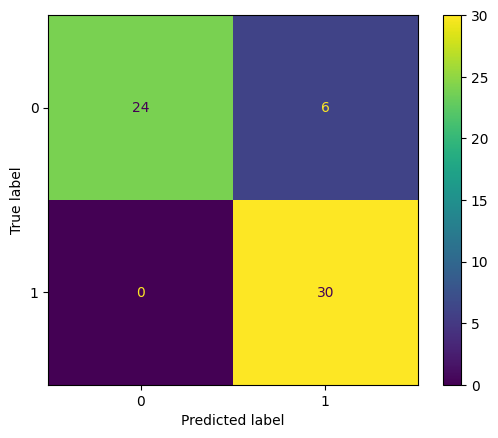

In [31]:
from sklearn import svm
svm=svm.SVC(gamma=0.001,kernel='linear',random_state=0).fit(X, y)
predicted_svm = svm.predict(PSDtest_a)
classification_report('svm model',test_labels,predicted_svm)
confusion_matrix(test_labels,predicted_svm)

In [32]:
# find out which 6 have wrong predict labels on SVM
combine_labels=np.concatenate((predicted_svm.reshape(60,1),test_labels), axis=1)
L=[]
for i in range(0,len(combine_labels)):
    if combine_labels[i][0]!=combine_labels[i][1]:
        L.append(i)
print('The index of predicted wrong labels are: %s'
      % str(L))

The index of predicted wrong labels are: [20, 22, 23, 29, 39, 51]
